In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow.python.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Concatenate
from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, LeakyReLU
from tensorflow.python.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.python.keras import metrics
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.optimizers import Adam

import pdb
import os

from train_model_template.helpers_vizualisation import eval_knn_proportions
from train_model_template.helpers_vizualisation import plot_tsne
from train_model_template.helpers_vizualisation import plot_umap


In [6]:
from __future__ import print_function, division

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import SGD



In [7]:
# note: after discussion last time the data has one concatanated index with all the information
def load_data_basic(path, patient='sample1', batch_names = ['batch1', 'batch2'], seed=42,
                   n_cells_to_select = 500):
    """
    Function to load data and split into 2 inputs with train and test sets
    inputs:
        path: path to the data file
        patient: name of the patient to consider
        batch_names: a list of batch names to split the data
        n_cells_to_select: number of cells to select for quicker runs, if 0 then all cells are selected
    outputs:
        x1_train, x1_test: train and test sets form the first batch
        x2_train, x2_test: train and test sets form the second batch    
    """
    df = pd.read_parquet(path, engine='pyarrow')
    selected_cols = [col for col in df.columns if not "metadata" in col]
    df = df.loc[:,selected_cols]
    idx = df.index.get_values()
    x1_idx = [x for x in idx if patient in x and batch_names[0] in x and patient+'0' not in x][0]
    x1 = df.loc[x1_idx,:].copy()
    x2_idx = [x for x in idx if patient in x and batch_names[1] in x and patient+'0' not in x][0]
    x2 = df.loc[x2_idx,:].copy()
    if(n_cells_to_select>0):
        cells_to_select = np.random.uniform(0,x1.shape[0], n_cells_to_select)
        x1 = x1.iloc[cells_to_select, :]
        cells_to_select = np.random.uniform(0,x2.shape[0], n_cells_to_select)
        x2 = x2.iloc[cells_to_select, :]
    x1_train, x1_test = train_test_split(x1, test_size=0.2, random_state=42)
    x2_train, x2_test = train_test_split(x2, test_size=0.2, random_state=42)
    return(x1_train, x1_test, x2_train, x2_test)


In [4]:
############# DATA LOADING ############# 

In [8]:
path = '/Users/laurieprelot/Documents/Projects/2019_Deep_learning/data/simulated'

In [9]:
#path = os.getcwd()
path = os.path.join(path,'toy_data_gamma_small.parquet') # '/toy_data_gamma_large.parquet'
x1_train, x1_test, x2_train, x2_test = load_data_basic(path, patient='sample1', batch_names = ['batch1', 'batch2'], seed=42,
                                                      n_cells_to_select=0)

In [10]:
x2_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
batch2_sample1,3.832489,23.855709,20.957669,13.850738,5.346237,13.745676,9.121335,4.727064,24.253307,13.054695,5.849181,8.009699,17.438050,16.503502,19.035658,11.756811,5.608161,12.270049,25.371968,18.183235
batch2_sample1,9.880713,19.073916,9.783921,9.450616,12.093096,20.737565,10.190262,16.931007,7.790722,12.898835,5.941291,7.150282,6.722189,12.026421,11.565301,15.018530,15.153351,17.272597,13.159564,18.601612
batch2_sample1,29.390741,15.564417,31.965034,4.538834,30.589117,31.846044,20.944043,26.212574,9.940314,4.063715,21.073096,10.262750,10.113188,14.644070,19.904254,8.397279,6.585889,10.377389,15.181359,9.731903
batch2_sample1,7.268105,32.187670,11.552404,7.727870,13.536621,8.073538,8.521434,14.003197,32.326215,10.748061,15.234809,13.070618,6.047054,9.156604,5.196233,6.734580,2.923731,22.819821,19.854966,10.900061
batch2_sample1,8.486861,15.975259,23.599617,6.066593,7.256278,21.920306,6.767162,17.483637,43.309543,6.089442,8.575041,6.820581,4.242966,12.477840,27.165986,7.559497,5.034593,36.847762,20.213553,6.191045


In [11]:
#############    MODEL     #############

In [12]:
### !!!!!
class models_gans(tf.keras.Model):  
    ''' model_type = generator, discriminator, 'combined'''
    def __init__(self, model_type):
        super(models_gans, self).__init__(name='')
        self.model_type = model_type
        self.Dense = {}
        for i in [10, 15, 20, 30, 512, 256]:
            self.Dense[str(i)] = tf.keras.layers.Dense(i)
        self.Lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
        #self.bn = tf.keras.layers.BatchNormalization(momentum=0.8)
        self.densetanh = tf.keras.layers.Dense(20, activation='tanh')
        self.sigmoid = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def generator(self, input_tensor, training = True):
        x = self.Dense[str(20)](input_tensor)
        x = self.Lrelu(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
        
        x = self.Dense[str(15)](x)
        x = self.Lrelu(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

        x = self.Dense[str(10)](x)
        x = self.Lrelu(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

        #x += input_tensor # ADD BACK 
        
        x = self.densetanh(x)
        x.trainable = training
        return x
        
    def discriminator(self, input_tensor, training = True):
        x = self.Dense[str(512)](input_tensor)
        x = self.Lrelu(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
        
        x = self.Dense[str(256)](input_tensor)
        x = self.Lrelu(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
        
        x = self.sigmoid(x)
        x.trainable  = training
        return x
        
        
    def call(self, input_tensor, training = False):
        if self.model_type == 'generator':
            x = self.generator(input_tensor, training = True)
        elif self.model_type == 'discriminator':
            x = self.discriminator(input_tensor, training = True)

        if self.model_type == 'combined':
            x = self.generator(input_tensor, training = False)
            x = self.discriminator(x, training = True)
        return x

In [44]:
### !!!!!
class GAN_residuals():
    ''' batch1 and batch2 are pandas dataframes with batch 1 and batch 2 respectively and no metadata or index'''
    def __init__(self, batch1, batch2):
        # batches
        self.batch1 = batch1
        self.batch2 = batch2
        
        #parameters 
        self.data_size = batch1.shape[1]
        optimizer = Adam(0.0002, 0.5)
     
        

        # Build and compile the discriminator
        self.discriminator = models_gans('discriminator')
        #_ = self.discriminator(tf.zeros((1, batch1.shape[1])))
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        
        # Build the generator
        self.generator = models_gans('generator')
        #self.generator.compile(loss='binary_crossentropy',
        #    optimizer=optimizer,
        #    metrics=['accuracy'])
        
        
        
        # The generator takes x1 as input and generates gen_x1 (fake x2)
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        x1 = Input(shape=(self.data_size,))
        gen_x1 = self.generator(x1)
        validity = self.discriminator(gen_x1) 
 
        
        self.combined = models_gans('combined')
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        _ = self.combined(tf.zeros((1, batch1.shape[1])))
        self.combined.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

        
    def train(self, epochs, batch_size=128, sample_interval=50):
        plot_model = {"epoch":[],"d_loss":[],"g_loss":[]}
        x1 = self.batch1.values
        x2 = self.batch2.values

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of x1 and x2
            idx = np.random.randint(0, x1.shape[0], batch_size)
            x1 = x1[idx]
            x2 = x2[idx]

            # Generate a batch of new images
            gen_x1 = self.generator.predict(x1, verbose = 1)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(x2 , valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_x1 , fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
  

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(x1, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
            plot_model["epoch"].append(epoch)
            plot_model["d_loss"].append(d_loss[0])
            plot_model["g_loss"].append(g_loss[0])

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_x2(epoch, x1)
        return plot_model

    def sample_x2(self, epoch, x1):
        r, c = 5, 5
        gen_x2 = self.generator.predict(x1)
        # can e.g. save some pca figures of the gen_x2



In [40]:
gan = GAN_residuals(x1_train, x2_train)
plot_model  = gan.train(epochs=20, batch_size=32, sample_interval=200)


32/32 [==============================] - 0s 2ms/sample


ValueError: ('Error when checking model input: expected no data, but got:', array([[22.51983318, 10.39646107, 23.7418161 , 11.69080243, 35.2022957 ,
        36.1955743 , 14.84535811, 18.47948061, 36.67710726, 12.3604606 ,
         6.05917779, 10.83859635, 13.99131333, 17.20095391, 17.59008649,
        20.82754248, 19.89658766, 10.76773757, 15.42470155, 15.09042127],
       [ 2.01401258,  3.85498322,  7.51764227, 14.75192582,  9.2523446 ,
        15.23683736,  8.77760878,  8.00209437,  9.98589708, 11.01672311,
        17.76897375,  7.37967871, 12.45200977, 21.44808596, 10.80188181,
        25.89342692,  2.88368823, 23.16519907, 13.3151004 , 26.23920743],
       [14.7052989 ,  6.28765935, 13.18735416,  6.45566872, 20.18000646,
         7.4097234 , 17.46095286, 14.56252916, 32.34681873,  1.13777909,
        12.93941907,  4.03973765,  8.17567555,  5.79518348,  9.85062491,
        17.062065  ,  6.1565323 , 13.97315162, 25.2115813 , 12.22898344],
       [ 6.16520957, 11.53956367,  8.35955694, 14.029004  , 32.64339579,
        51.49936064,  6.69976449, 34.80437942, 19.92261379,  2.38822218,
         2.46155292, 10.96053929, 15.01572826,  9.25672486, 18.70309924,
        20.20100805, 14.53013425, 17.88305213,  5.66884182, 18.67140497],
       [15.71858846,  4.72474157, 19.70370861,  3.41902841, 15.11256514,
        27.64745758,  8.71145598,  6.27640876,  6.00304586,  5.73468152,
         6.74676774, 17.7952344 ,  8.26074756, 29.73937485, 28.2581841 ,
        11.55463791,  7.52521339, 10.01255771, 14.22905469,  4.58646071],
       [ 9.09616245, 15.43244329, 30.37060679, 21.58221907, 10.77722786,
         5.73458059,  7.04253199,  7.00033916, 22.80039376,  8.6323268 ,
        14.50549126,  4.53798532,  4.16394989, 21.55962477, 12.13652207,
         8.23429639,  4.15478341, 37.36356289,  7.59702552, 15.84933113],
       [36.82156047,  7.26577535, 21.05596807, 12.32111967,  9.94658778,
         6.64168066, 15.72215281, 10.54413243, 12.02505794,  6.42004175,
        10.62857117, 25.08815166, 13.5179786 , 24.34453506,  3.7235271 ,
        12.60377461, 20.6087603 ,  4.64672114,  6.13166898, 20.67035116],
       [ 4.93330177, 24.5483771 , 33.56482286,  4.1492299 ,  7.50272301,
        12.98083765,  7.18535749,  8.72947035,  5.48519137,  8.05442618,
        22.48991951, 27.89648327, 22.83058947, 16.93268572, 15.20296189,
        23.95301434,  5.34834931, 10.97285642,  8.79289194, 15.88633802],
       [ 4.48713325, 16.73854771,  5.94030264,  3.58999099, 15.80866839,
         7.03772334,  7.80552831, 10.78632627,  4.93763393,  6.18742595,
        15.70794314, 15.70993265, 28.70677389, 19.88417782, 11.25838263,
        23.57652007, 14.5179491 ,  3.20699905, 21.32367449,  5.3368897 ],
       [ 8.28795421,  4.09623344, 24.31615897, 15.22299536, 36.89941501,
        24.09702811, 11.7464519 , 16.33035523, 17.30004743,  9.03242925,
        12.04778849,  5.9174057 ,  5.70195494, 17.88430256,  9.59449796,
        28.36343449, 13.40866782, 10.86384846, 13.59490222, 21.07770243],
       [ 5.17086008, 19.60357178,  7.6565645 , 15.05963834, 45.66396656,
        16.49015234, 17.20371672, 15.5162304 ,  6.53719179, 19.89451137,
        10.65384442,  7.26349603, 15.15423183, 18.73191617, 13.05504669,
        12.25037798,  3.80227967,  8.13765474,  6.85652472,  8.9767905 ],
       [ 3.66683309, 12.2237506 , 14.02010238,  6.57046905,  7.88193432,
        12.73572921,  7.76226232, 13.29133114,  6.65843964, 17.54839262,
        16.91510531,  5.3131338 , 18.68365364, 24.90313931, 18.77260372,
        14.33378664, 12.40911792, 18.38631599, 27.57808631, 14.4506287 ],
       [17.56521016, 39.91513886, 16.97921462, 10.21344347, 32.42679248,
        27.80151689,  2.49930924, 12.34726185,  9.72660447, 18.42109872,
        26.75222659, 30.4633518 , 21.96672758,  9.22770133, 16.18143584,
        10.23414957,  5.86196514, 19.87027562, 19.11307723, 15.66362768],
       [ 2.60070766, 41.68930006, 15.56082412, 16.10890432, 31.76756046,
        44.07494198,  6.36648302, 11.11820403,  9.61297279, 19.2196827 ,
        15.79582705, 12.47845069, 17.38306095, 18.28707141, 13.22601785,
        15.89444784,  6.06896634, 15.51010043, 24.10777129, 11.94040896],
       [ 6.91743976, 19.50612612, 39.03311669,  8.88365179, 26.32733543,
        21.18156271, 27.18469427, 14.72398281, 14.33505627, 13.15519306,
        13.5396938 ,  7.19422452, 13.17906614, 18.34377502, 26.10597814,
         4.46570341,  4.34214099, 18.84661034, 30.70531122,  6.93488577],
       [22.07067363, 17.63058325, 14.78961558, 10.90658192,  6.39923891,
        11.73923598,  4.09026365,  9.4040991 ,  9.14502286,  6.92896954,
         7.98080954, 15.04480305, 11.73451489, 15.68190981, 11.50086454,
        22.32024791, 23.76063143, 12.09541389, 27.4390082 , 34.14748776],
       [20.25353386, 21.01118535, 29.09009358, 10.1537643 ,  6.09694602,
         3.24073778, 13.65126734, 12.70212066, 12.79360616,  6.65781515,
        21.05041918, 12.24774704, 24.42561887, 15.41402829, 15.39064289,
        17.40492974, 16.46407999, 35.13407781, 12.32456552,  4.29547506],
       [15.90088702, 17.53740352, 24.29626559, 23.3305894 , 21.1376185 ,
         3.76818533, 10.17143009, 23.59338539, 29.51350182, 22.10607556,
         3.6689938 , 10.16932799, 16.61975951,  3.45503451, 37.00588557,
        16.46979488,  9.85695502, 21.80160538, 18.15284662, 11.81770888],
       [ 5.84065647, 10.71827265, 23.61020572,  8.67871324, 42.41862995,
        14.86320749, 14.76469177, 23.13490493, 17.2084347 ,  9.31188454,
        27.48221103, 22.46541734, 19.51775496, 47.31083933, 15.14336795,
        13.59086944,  6.80454298,  6.22415334, 13.33930042,  7.26446635],
       [22.09150366,  2.7643393 , 35.07450816, 11.04664755, 22.06303063,
         7.86812297,  7.48129135,  3.56987499, 30.71885015,  2.92247855,
         9.26448076,  5.31061892, 27.00091876,  3.36867396, 15.76554923,
        19.90003855, 17.78929253, 12.82777437, 12.86722903, 10.28957048],
       [12.10128344,  8.6729291 , 23.61363057,  8.28321099, 12.91437835,
        34.8075479 , 15.60335942, 15.59049314, 41.45523921, 12.41009697,
        10.98776094, 10.66808982,  9.30856156,  7.56805835, 15.05117147,
        15.26752895,  7.85605038, 18.61743888, 11.7056391 , 18.45009627],
       [ 9.7476814 , 35.09689094, 27.62203885, 23.68243339,  6.43825765,
        39.73805228, 16.10300688,  8.47729678, 23.7870662 ,  5.41491882,
         8.38753058,  4.69645186, 14.54081432, 13.74233635,  7.11002008,
        12.5003736 , 14.21341102, 25.92342344, 11.73205969, 18.46970097],
       [16.43986743,  6.28509216,  5.88564152, 14.37140664, 14.10452007,
         2.38684741, 14.54172579, 15.5668629 ,  8.71102367, 19.66423234,
         7.89953177,  9.95539213,  8.33056951,  8.26310704, 14.0027766 ,
        13.10134778,  6.48750308, 26.27006405, 14.2615514 , 11.00610148],
       [19.33854284, 15.476353  , 16.93631911,  4.9489628 , 21.60162662,
        12.35812772, 14.03425244, 24.54255164,  6.23493856,  6.78973475,
        10.50456502, 31.52704923, 15.77470118,  4.38708603, 24.86687106,
        19.09926255,  4.397319  , 11.24777308, 16.55538565, 13.71781657],
       [14.06540895,  5.48855311, 15.85960335,  7.71916286, 14.60021204,
        12.2932293 ,  7.61714006, 14.40463599, 12.99531998, 22.37857824,
         6.93928068,  8.38264622, 12.19468552, 24.43592518, 30.06710952,
        17.86076943,  6.01305518, 13.14037916, 21.63682211, 16.27664947],
       [ 7.48779349, 19.31517757, 25.57331083, 11.24362077, 57.20969823,
         4.76915512,  3.70810833, 11.86902723, 15.46623269,  8.94929086,
        11.35618676, 24.49542467, 12.43705978,  7.55053608, 21.0947841 ,
        14.5229844 ,  3.97739612, 12.99926161, 21.90534399, 28.18693396],
       [10.34885049, 29.73124941, 26.16693412,  8.78525534, 27.83832668,
        13.09025113, 10.9337031 , 13.1097724 ,  9.22520829, 15.01983922,
         3.69890419,  9.58119607, 12.06717113, 18.85932985, 14.49645152,
         9.59177427,  6.73288432, 16.24264519, 21.54766789, 72.65041727],
       [ 7.35896323, 10.03074591, 10.32299733, 13.88840807,  6.87690794,
         6.26462372,  9.32588772, 10.07764812, 16.25102717, 10.91493652,
         7.59026713,  5.77364788, 11.52367514,  9.30267587, 25.43400918,
        18.41806699,  9.26855408, 10.20784826, 20.09747495,  4.85172031],
       [ 7.35367807,  7.87319821,  5.72588222,  2.95599508, 16.08278719,
        15.59603865,  8.83343889, 14.21748935,  9.38722498, 13.26113166,
         7.91097439,  4.1388033 , 23.48309292, 10.95306937, 17.76472723,
        22.24140879,  8.77221441, 14.39938175, 30.74413762, 23.30643053],
       [13.10904038, 17.12382728, 17.96434   , 14.83438315, 13.75533595,
        27.18256104,  2.34425111,  8.82847347,  9.00790879, 13.07763014,
        13.19593173, 10.53920675,  6.30811859, 11.17629956, 14.28215356,
         5.77525828, 20.16637773,  5.11532747, 13.497176  , 10.06674178],
       [ 2.01401258,  3.85498322,  7.51764227, 14.75192582,  9.2523446 ,
        15.23683736,  8.77760878,  8.00209437,  9.98589708, 11.01672311,
        17.76897375,  7.37967871, 12.45200977, 21.44808596, 10.80188181,
        25.89342692,  2.88368823, 23.16519907, 13.3151004 , 26.23920743],
       [17.931705  , 12.90627038, 16.30136853, 13.64900852, 33.09998725,
         2.96120564, 10.62026934,  9.46210801, 12.70459556, 13.59773633,
        13.10381471, 15.35178308,  7.89068255, 32.69206988, 10.09249694,
        14.45533191, 12.66596744, 18.87775185, 12.96037235, 17.75438335]]))

In [19]:
# class MLP(tf.keras.Model):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.Lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)
#         #self.bn = tf.keras.layers.BatchNormalization(momentum=0.8)
#         self.densetanh = tf.keras.layers.Dense(20, activation='tanh')
#         self.sigmoid = tf.keras.layers.Dense(1, activation='sigmoid')
#         self.dense_1 = Dense(20, activation='relu')
#         self.dense_4 = Dense(10)
#         self.dense_2 = Dense(15)
#         self.dense_3 = Dense(20)

#     def call(self, inputs):
#         x = self.dense_1(inputs)
#         x = self.Lrelu(x)
#         x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
        
#         x = self.dense_2(x)
#         x = self.Lrelu(x)
#         x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)

#         x = self.dense_3(x)
#         x = self.Lrelu(x)
#         x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
#         return x

# # Instantiate the model.
# mlp = MLP()
# # Necessary to create the model's state.
# # The model doesn't have a state until it's called at least once.
# #_ = mlp(tf.zeros((1, 20)))
#mlp.predict(x1_train[1:128].values, verbose = 1)


In [ ]:
############# VISUALIZATIONS ############# 

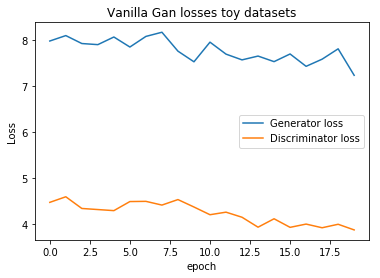

In [286]:
plot_dir = '/Users/laurieprelot/Documents/Projects/2019_Deep_learning/data/plots_gans'
plt.plot(plot_model["epoch"], plot_model["g_loss"], label = 'Generator loss')
plt.plot(plot_model["epoch"], plot_model["d_loss"], label = 'Discriminator loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
mytitle = "Vanilla Gan losses toy datasets"
plt.title(mytitle)
plt.savefig(os.path.join(plot_dir, mytitle.replace(' ', '_') + '.pdf'), bbox_anchor = 'tight')

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 206 samples in 0.003s...
[t-SNE] Computed neighbors for 206 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 206 / 206
[t-SNE] Mean sigma: 5.471454
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.509445
[t-SNE] KL divergence after 500 iterations: 1.341254


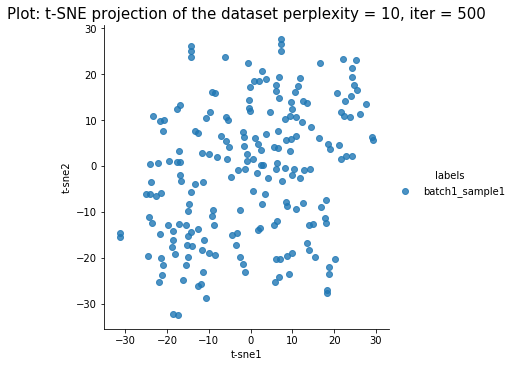

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 206 samples in 0.000s...
[t-SNE] Computed neighbors for 206 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 206 / 206
[t-SNE] Mean sigma: 5.980623
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.199615
[t-SNE] KL divergence after 500 iterations: 1.234557


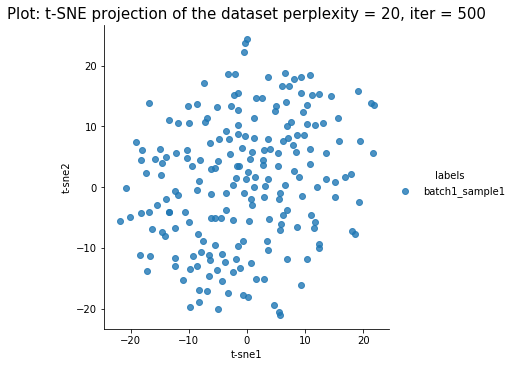

In [13]:
# note: x1_test should be replaced with with model output
plot_tsne(x1_test, do_pca = True, n_plots = 2, iter_ = 500, pca_components = 20)

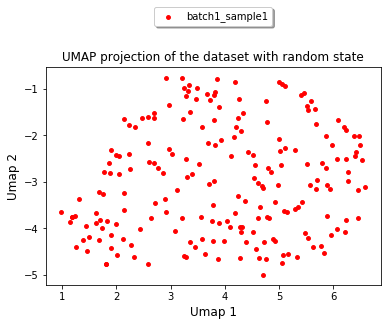

In [14]:
plot_umap(x1_test)

In [ ]:
#eval_knn_proportions(x1_test)